In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle

Setting permission to owner alone

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

Downloading dataset from kaggle using API command

In [7]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:13<00:00, 117MB/s] 
100% 1.03G/1.03G [00:13<00:00, 84.4MB/s]


In [8]:
!unzip asl-alphabet.zip -d asl-alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alp

In [9]:
!pip install imutils

In [10]:
# importing main modules
import warnings
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

#Visualization modules
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Modules for model building
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [11]:
class CFG:
  batch_size = 64
  img_height = 64
  img_width = 64
  epochs = 10
  num_classes = 29
  img_channels = 3

def seed_everything(seed: int):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

In [12]:
# Labels
TRAIN_PATH = "/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


Creating Metadata

In [13]:
list_path = []
list_labels = []
for label in labels:
  label_path = os.path.join(TRAIN_PATH, label, "*")
  image_files = glob.glob(label_path)

  sign_label = [label]*len(image_files)

  list_path.extend(image_files)
  list_labels.extend(sign_label)

metadata = pd.DataFrame({"image_path": list_path, "label":list_labels})

Split Dataset to Train 0.7, Val 0.15, and Test 0.15

In [14]:
x_train, x_test, y_train, y_test = train_test_split(metadata['image_path'], metadata['label'], test_size=0.15, random_state=0, shuffle=True, stratify=metadata['label'])
data_train = pd.DataFrame({"image_path":x_train, "label":y_train})
data_test = pd.DataFrame({"image_path":x_test, "label":y_test})

x_train, x_val, y_train, y_val = train_test_split(data_train["image_path"], data_train['label'], test_size=0.15/0.70, random_state=0, shuffle=True, stratify=data_train['label'])
data_val = pd.DataFrame({"image_path":x_val, "label":y_val})
data_train = pd.DataFrame({"image_path":x_train, "label":y_train})


Data augmentation

In [15]:
def data_augmentation():
  datagen =ImageDataGenerator(rescale=1/255.,)
  train_generator = datagen.flow_from_dataframe(data_train, directory="./",
                    x_col="image_path", y_col="label", class_mode="categorical",
                    batch_size=CFG.batch_size, target_size=(CFG.img_height, CFG.img_width),)

  validation_generator = datagen.flow_from_dataframe(data_val, directory="./",
                    x_col="image_path", y_col="label", class_mode="categorical",
                    batch_size=CFG.batch_size, target_size=(CFG.img_height, CFG.img_width),)

  test_generator = datagen.flow_from_dataframe(data_test, directory="./",
                    x_col="image_path", y_col="label", class_mode="categorical",
                    batch_size=CFG.batch_size, target_size=(CFG.img_height, CFG.img_width),)

  return train_generator, validation_generator, test_generator

In [16]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


Model Building

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

None

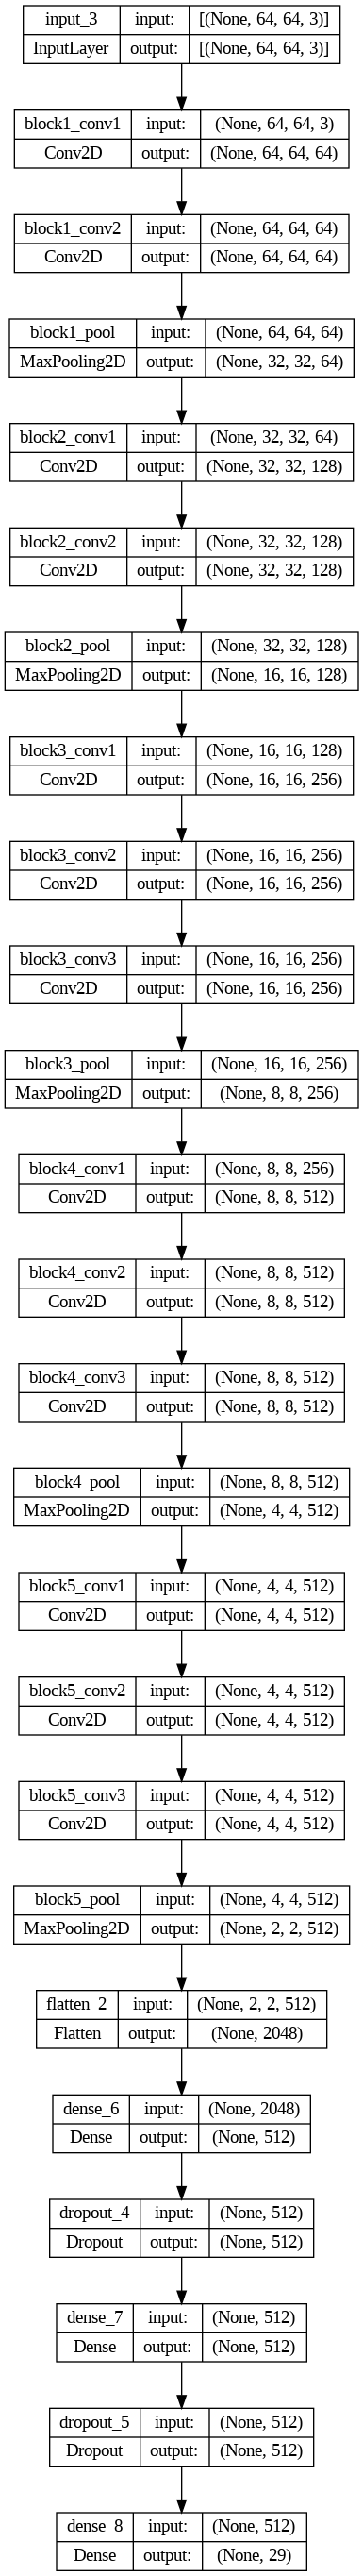

In [23]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)
display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

In [24]:
#compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=["accuracy"])

#callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_loss', mode = 'min')

In [25]:
for batch in train_generator:
  x_batch, y_batch = batch
  print("batch shape: ", x_batch.shape)
  print("data type: ", x_batch.dtype)
  break

batch shape:  (64, 64, 64, 3)
data type:  float32


In [26]:
input_layer = model.layers[0]
input_shape = input_layer.input_shape
input_shape

[(None, 64, 64, 3)]

In [27]:
history = model.fit(train_generator, steps_per_epoch=train_generator.samples // CFG.batch_size,
                    epochs=CFG.epochs, validation_data=validation_generator,
                    validation_steps=validation_generator.samples // CFG.batch_size, callbacks=[checkpoint])

Epoch 1/10
907/907 [==============================] - 3153s 3s/step - loss: 1.0806 - accuracy: 0.6581 - val_loss: 0.2242 - val_accuracy: 0.9367


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
907/907 [==============================] - 3076s 3s/step - loss: 0.3976 - accuracy: 0.8658 - val_loss: 0.1149 - val_accuracy: 0.9670
Epoch 3/10
907/907 [==============================] - 3080s 3s/step - loss: 0.2874 - accuracy: 0.9012 - val_loss: 0.0819 - val_accuracy: 0.9768
Epoch 4/10
907/907 [==============================] - 3041s 3s/step - loss: 0.2427 - accuracy: 0.9173 - val_loss: 0.0706 - val_accuracy: 0.9811
Epoch 5/10
907/907 [==============================] - 3087s 3s/step - loss: 0.2131 - accuracy: 0.9266 - val_loss: 0.0773 - val_accuracy: 0.9749
Epoch 6/10
907/907 [==============================] - 3059s 3s/step - loss: 0.1950 - accuracy: 0.9333 - val_loss: 0.0560 - val_accuracy: 0.9832
Epoch 7/10
907/907 [==============================] - 3072s 3s/step - loss: 0.1793 - accuracy: 0.9400 - val_loss: 0.0485 - val_accuracy: 0.9872
Epoch 8/10
907/907 [==============================] - 3108s 3s/step - loss: 0.1630 - accuracy: 0.9435 - val_loss: 0.0497 - val_accuracy:

Model Evaluation

In [29]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("evaluate Test Accuracy", scores[1]*100))

204/204 [==============================] - 537s 3s/step - loss: 0.0325 - accuracy: 0.9928
evaluate Test Accuracy: 99.28%


In [31]:
# confusion matrix
fine_tuned_model = load_model("/content/asl_vgg16_best_weights.h5")
predictions = fine_tuned_model.predict(test_generator)

# Getting the labels form the generator
true_labels = test_generator.classes

# compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(labels=true_labels, predictions=predictions.argmax(axis=1), num_classes=29)

204/204 [==============================] - 534s 3s/step


In [34]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs = fine_tuned_model.layers[-1].output)
dense_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [36]:
# extracting features in dense layer

def dense_feature_prediction(img_path):
  img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
  img = img_to_array(img)
  img = img/255.
  img = np.expand_dims(img, axis=0)
  dense_feature = dense_model.predict(img, verbose=0)[0]
  return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
  label_data = data_test[data_test["label"]==label][:100]
  reduction_data = reduction_data.append(label_data)

reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

dense_features = reduction_data["image_path"].progress_apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)

#TSNE Dimnesional Reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data


<ipython-input-36-e5245f22fcdb>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduction_data = reduction_data.append(label_data)
<ipython-input-36-e5245f22fcdb>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduction_data = reduction_data.append(label_data)
<ipython-input-36-e5245f22fcdb>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduction_data = reduction_data.append(label_data)
<ipython-input-36-e5245f22fcdb>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduction_data = reduction_data.append(label_data)
<ipython-input-36-e5245f22fcdb>:14: FutureWarning: The frame.append method is deprecated and will be removed fro

,image_path,label
0,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
1,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
2,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
3,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
4,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
...,...,...
2895,/content/asl-alphabet/asl_alphabet_train/asl_a...,space
2896,/content/asl-alphabet/asl_alphabet_train/asl_a...,space
2897,/content/asl-alphabet/asl_alphabet_train/asl_a...,space
2898,/content/asl-alphabet/asl_alphabet_train/asl_a...,space


100%|██████████| 2900/2900 [06:38<00:00,  7.28it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.001s...
[t-SNE] Computed neighbors for 2900 samples in 0.481s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.463917
[t-SNE] KL divergence after 1000 iterations: 0.168743


,image_path,label,tsne_feat_0,tsne_feat_1
0,/content/asl-alphabet/asl_alphabet_train/asl_a...,A,14.028865,-8.589529
1,/content/asl-alphabet/asl_alphabet_train/asl_a...,A,11.814671,-10.658160
2,/content/asl-alphabet/asl_alphabet_train/asl_a...,A,11.806844,-10.914112
3,/content/asl-alphabet/asl_alphabet_train/asl_a...,A,14.966569,-9.648602
4,/content/asl-alphabet/asl_alphabet_train/asl_a...,A,11.296180,-11.579964
...,...,...,...,...
2895,/content/asl-alphabet/asl_alphabet_train/asl_a...,space,-37.516762,7.064789
2896,/content/asl-alphabet/asl_alphabet_train/asl_a...,space,-37.410606,6.375655
2897,/content/asl-alphabet/asl_alphabet_train/asl_a...,space,-35.307594,8.348761
2898,/content/asl-alphabet/asl_alphabet_train/asl_a...,space,-35.862339,11.372965


Loading and testing the model

Test - 1

In [37]:
#Load the saved model
model = tf.keras.models.load_model("/content/asl_vgg16_best_weights.h5")
# Load the test image
image_path = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64,64))

# preprocessing the image
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

# Making predicitions on the image
predictions = model.predict(np.array([img]))

# Get the predicted class label

predicted_class = labels[np.argmax(predictions)]

print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 344ms/step
The predicted class is A


Test - 2

In [38]:
#Load the saved model
model = tf.keras.models.load_model("/content/asl_vgg16_best_weights.h5")
# Load the test image
image_path = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/C_test.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64,64))

# preprocessing the image
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

# Making predicitions on the image
predictions = model.predict(np.array([img]))

# Get the predicted class label

predicted_class = labels[np.argmax(predictions)]

print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 218ms/step
The predicted class is C


Test - 3

In [39]:
#Load the saved model
model = tf.keras.models.load_model("/content/asl_vgg16_best_weights.h5")
# Load the test image
image_path = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64,64))

# preprocessing the image
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

# Making predicitions on the image
predictions = model.predict(np.array([img]))

# Get the predicted class label

predicted_class = labels[np.argmax(predictions)]

print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 221ms/step
The predicted class is nothing


Test - 4

In [40]:
#Load the saved model
model = tf.keras.models.load_model("/content/asl_vgg16_best_weights.h5")
# Load the test image
image_path = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/space_test.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64,64))

# preprocessing the image
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

# Making predicitions on the image
predictions = model.predict(np.array([img]))

# Get the predicted class label

predicted_class = labels[np.argmax(predictions)]

print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 232ms/step
The predicted class is space
